<a href="https://colab.research.google.com/github/GymYJ/RNN_time-series/blob/master/rnn_smp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [508]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [509]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import os

tf.set_random_seed(777)  # reproducibility

def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 7
data_dim = 24
hidden_dim = 2
output_dim = 24
learning_rate = 0.01
iterations = 1000

# Open, Close
f = open('/content/gdrive/My Drive/Colab Notebooks/smp_land_2019.csv', 'rt', encoding='UTF8')
for i in range(4): f.readline() # 설명, 인덱스 부분 날리기
lines = f.readlines()
data = []
for line in lines:
    data.append(line.strip('\n').split(',')[1:-3])
data = np.array(data).astype(np.float)
xy = data[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

print(len(xy))
print(len(train_set))
print(len(test_set))
train_set.shape

361
252
116


(252, 24)

In [510]:

# Scale each
save_train = train_set
save_test = test_set
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, :]
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

print("build datasets done")


build datasets done


In [511]:
tf.reset_default_graph()
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 24])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 24])
predictions = tf.placeholder(tf.float32, [None, 24])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))


[step: 0] loss: 1680.5869140625
[step: 1] loss: 1507.110595703125
[step: 2] loss: 1385.7490234375
[step: 3] loss: 1306.5340576171875
[step: 4] loss: 1248.3148193359375
[step: 5] loss: 1194.758056640625
[step: 6] loss: 1140.090087890625
[step: 7] loss: 1084.2735595703125
[step: 8] loss: 1028.68798828125
[step: 9] loss: 974.4180908203125
[step: 10] loss: 921.928955078125
[step: 11] loss: 871.252197265625
[step: 12] loss: 822.2369384765625
[step: 13] loss: 774.7036743164062
[step: 14] loss: 728.5064697265625
[step: 15] loss: 683.5587158203125
[step: 16] loss: 639.859130859375
[step: 17] loss: 597.5170288085938
[step: 18] loss: 556.7574462890625
[step: 19] loss: 517.893310546875
[step: 20] loss: 481.2733154296875
[step: 21] loss: 447.2216796875
[step: 22] loss: 415.98638916015625
[step: 23] loss: 387.7052307128906
[step: 24] loss: 362.393798828125
[step: 25] loss: 339.9524841308594
[step: 26] loss: 320.188232421875
[step: 27] loss: 302.8464660644531
[step: 28] loss: 287.6438293457031
[step

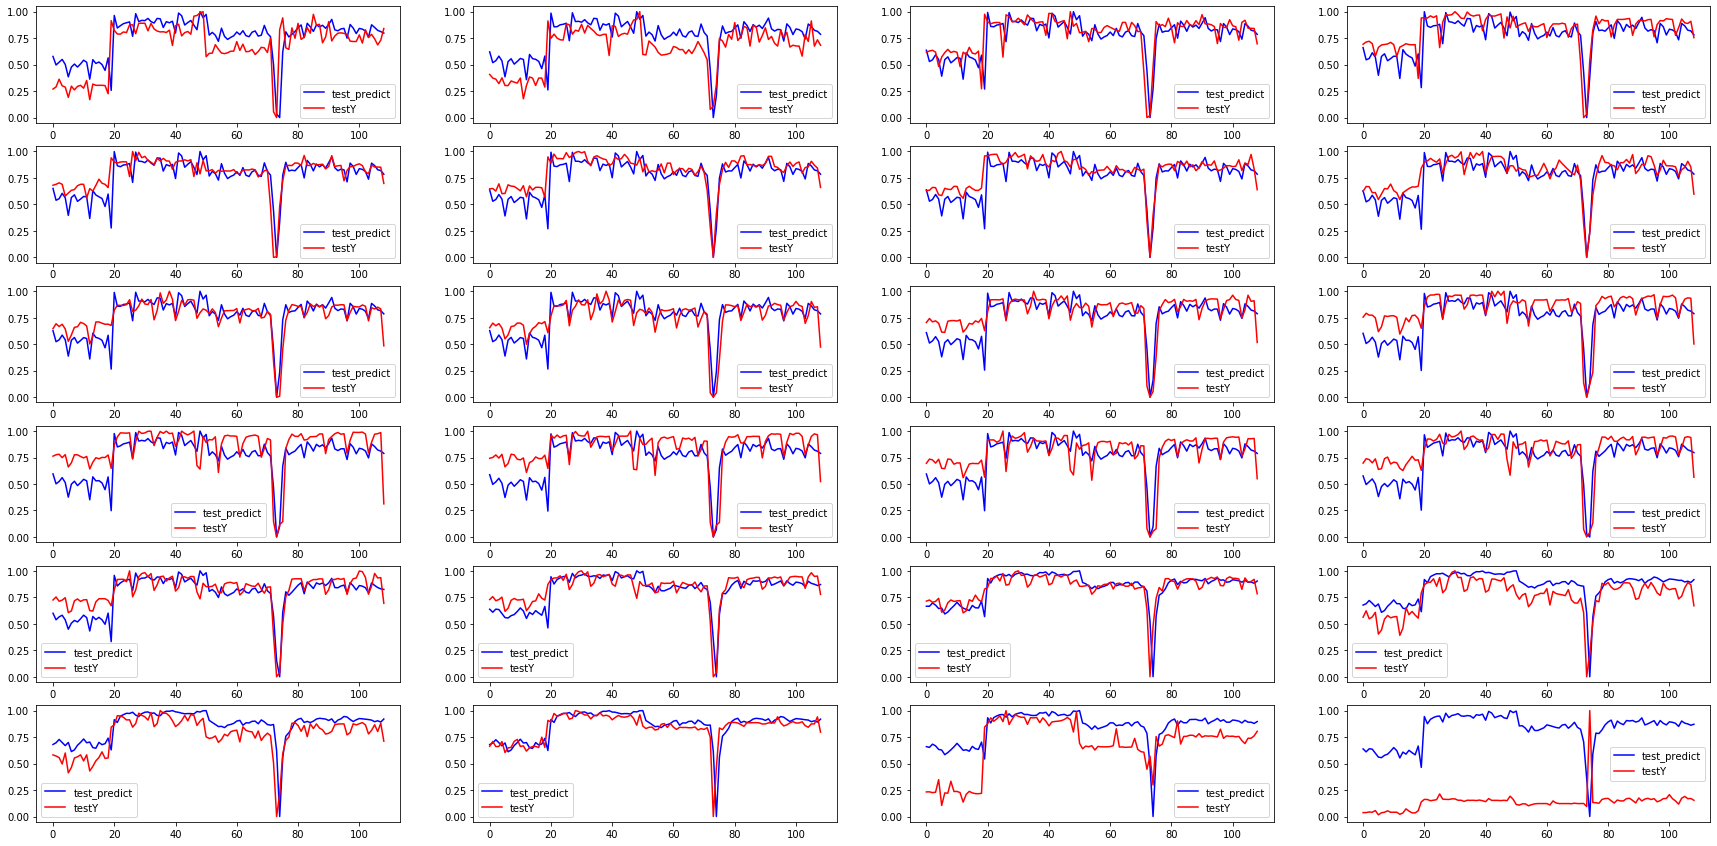

In [512]:
import matplotlib.pyplot as plt

# Plot predictions
plt.figure(figsize=(30, 15))
test_predict = MinMaxScaler(test_predict) # predict 값 0~1로 맞추기
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.plot(test_predict[:,i], c='blue', label='test_predict')
    plt.plot(testY[:,i], c='red', label='testY')
    plt.legend()
plt.show()